In [6]:
import jax
import matplotlib.pyplot as plt
# Randomness for the entire program
master_key=7 # Decides the output change d
key = jax.random.PRNGKey(master_key)
subkey, key = jax.random.split(key)

In [7]:
instances=30; # Number of data_point instances 

# The data_point samples are declared global
global X, Y, Noise_var

# Limits of the input data_pints
Lower_limit=0; 
Upper_limit=1;

True_bias=1
True_slope=1
Noise_var=0.02

# The input data_points are sampled uniformly in the interval specified by the limits
X=jax.random.uniform(subkey, [instances], minval=Lower_limit, maxval=Upper_limit)
subkey, key = jax.random.split(key)

# Noise, 'N' is generated
N=jax.numpy.sqrt(Noise_var) * jax.random.normal(subkey, [instances])
subkey, key = jax.random.split(key)

# Output data_points are generated as described in the text above.
Y = True_slope*X  +True_bias + N

In [8]:
def posterior(Est_bias, Est_slope):
  # Data_points and Noise variance to be read
  global X, Y, Noise_var

  # The likelihood and hence the posterior are computed in a 'proportional' manner here.
  # The value returned is the exponential of the sum squared distances
  sum=0
  for i in range(jax.numpy.size(X)):
    sum = sum-((Y[i]-X[i]*Est_slope-Est_bias) * (Y[i]-X[i]*Est_slope-Est_bias)/(2*Noise_var))
  return jax.numpy.exp(sum)

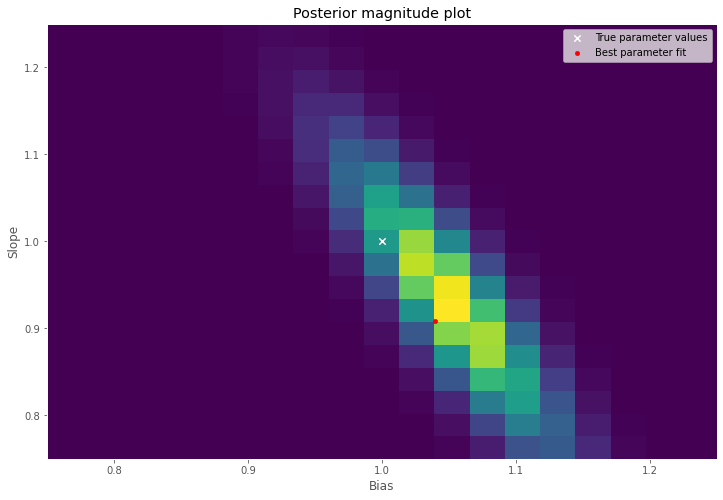

In [9]:
# Number of samples of the posterior along each parameter axis
No_of_posterior_points=20

# Parameter limits of the posterior distribution plot
lower_limit=0.75
upper_limit=1.25

# This variable stores the posterior values at the sample positions
Posterior_values = jax.numpy.zeros([No_of_posterior_points, No_of_posterior_points])
# This variable stores the bias values at the sample positions
Bias_points = jax.numpy.zeros([No_of_posterior_points, No_of_posterior_points])
# This variable stores the slope values at the sample positions
Slope_points = jax.numpy.zeros([No_of_posterior_points, No_of_posterior_points])

# SAMPLING THE POSTERIOR HERE
Current_posterior_max=-1
for i in range(No_of_posterior_points): # This loop changes bias values
  for j in range(No_of_posterior_points): # This loop changes slope values

    Bias_points = Bias_points.at[i,j].set(lower_limit + (upper_limit-lower_limit)*i/(No_of_posterior_points-1) )
    Slope_points = Slope_points.at[i,j].set(lower_limit + (upper_limit-lower_limit)*j/(No_of_posterior_points-1) )    
    Posterior_values = Posterior_values.at[i,j].set(posterior(Bias_points[i,j], Slope_points[i,j]))

    # Find the highest posterior value and the corresponding parameter values
    if(Posterior_values[i,j] > Current_posterior_max):
      Current_posterior_max = Posterior_values[i,j]
      Bias_prediction = Bias_points[i,j]
      Slope_prediction = Slope_points[i,j]

# Plotting the sampled posterior here as a color map
fig, ax = plt.subplots()
ax.pcolormesh(Bias_points, Slope_points, Posterior_values)
ax.scatter(True_bias, True_slope, s=40, c='white', marker='x', label='True parameter values')
ax.scatter(Bias_prediction, Slope_prediction, s=20, c='red', label='Best parameter fit')
plt.title("Posterior magnitude plot")
plt.xlabel("Bias")
plt.ylabel("Slope")
plt.legend();

In [10]:
# Normalizing the posterior PDF
Posterior_values = Posterior_values/jax.numpy.sum(Posterior_values)

# Initializing the posterior CDF
Posterior_CDF = jax.numpy.zeros([No_of_posterior_points,No_of_posterior_points])

# Creating the approximate posterior CDF from the sampled PDF
sum=0
for i in range(No_of_posterior_points):
  for j in range(No_of_posterior_points):
    sum = sum+Posterior_values[i,j];
    Posterior_CDF = Posterior_CDF.at[i,j].set(sum)

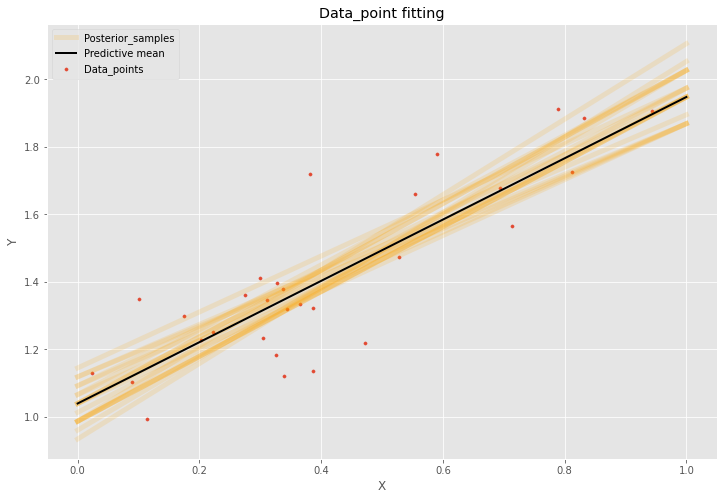

In [11]:
No_of_parameter_samples=18; # Number of posterior samples
plot_points=jax.numpy.linspace(Lower_limit, Upper_limit, 100) # Plotting points range
fig, ax = plt.subplots()

for instance in range(No_of_parameter_samples):
  # Sampling the uniform random variable
  CDF_value = jax.random.uniform(subkey, [1], minval=0, maxval=1)
  subkey, key = jax.random.split(key)

  # Converting the uniform random variable samples to posterior samples
  found=0
  for i in range(No_of_posterior_points):
    for j in range(No_of_posterior_points):
      if(Posterior_CDF[i,j] > CDF_value):
        found=1;
        Bias_sample = Bias_points[i,j];
        Slope_sample = Slope_points[i,j];
        break
    if(found == 1):
        break
  
  # Plotting the posterior samples
  ax.plot(plot_points, Bias_sample+(Slope_sample*plot_points), color="orange", linewidth=5, alpha=0.15)
ax.plot(plot_points, Bias_sample+(Slope_sample*plot_points), color="orange", linewidth=5, alpha=0.15, label='Posterior_samples')  

# Plotting the predictive mean(ML on parameters)
ax.plot(plot_points, Bias_prediction+Slope_prediction*plot_points, color="black", linewidth=2, label='Predictive mean')

# Plotting the data points
plt.scatter(X, Y, s=10, label='Data_points')
plt.legend()
plt.title("Data_point fitting")
plt.xlabel("X")
plt.ylabel("Y");